In [1]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2023-03-17 18:24:21.427319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 18:24:21.427382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-17 18:24:21.427389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


### Load and process data

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [5]:
data = pd.read_pickle('../../data/data_proton_photonsum_15_2133.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

# Data containing particle conditional data from particle having responses with proton photon sum in interval [70, 2312] without taking into consideration photon sums of neutron responses.
data_cond = pd.read_pickle('../../data/data_cond_photonsum_15_2133_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (48714, 56, 30) max: 678.0
Loaded cond:  (48714, 12) max: 7000.0 min: -7000.0


In [6]:
# calculate min max proton sum
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()

In [7]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum', 'Pdg'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge'], dtype='object'),
 9)

In [8]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0


In [9]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "vae"

EXPERIMENT_DIR_NAME = f"{NAME}_{int(photon_sum_proton_min)}_{int(photon_sum_proton_max)}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  vae_15_2133_17_03_2023_18_24


In [10]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [11]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    filepath = f"../models/{EXPERIMENT_DIR_NAME}/"
    create_dir(filepath)
    with open(filepath+out_fnm, mode="w") as f:
        f.write(res)

In [12]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.5206213 min 0.0


In [13]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(38971, 56, 30) (9743, 56, 30) (38971, 9) (9743, 9)


In [14]:
scaler = StandardScaler()
# scale cond datascaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

cond max 22.267750474560664 min -37.89385322476621


In [15]:
# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

### Define Model

In [16]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 9
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56,30,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond,x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=(1,3) ,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 56, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 15, 32)   544         ['input_img[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 64)    32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 4, 128)    131200      ['conv2d_1[0][0]']               
                                                                                            

In [17]:
#trainin params

EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16


START_GENERATING_IMG_FROM_IDX = 20
# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[START_GENERATING_IMG_FROM_IDX:START_GENERATING_IMG_FROM_IDX+num_examples_to_generate]

### function to calculate ws distance between orginal and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1, 56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

In [18]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws = np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,30,1)), reconstruction), axis=(1, 2)
            )
        )
        # kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        # kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # total_loss = 0.7 * kl_loss + reconstruction_loss  
        total_loss = reconstruction_loss
        kl_loss = 0
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))
    
    return total_loss, reconstruction_loss, kl_loss

In [19]:
filepath_mod = f"../../models/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_mod)

history = []
history_loss = []
def train(dataset, epochs):
    tf_step = tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                             epochs,
                             [seed, seed_cond])
    #print(calculate_ws_mae(3))
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epoch,
                               [seed, seed_cond])

        generate_and_save_images(generator,
                                 epoch + 1,
                                 [seed, seed_cond]
                                 )

        # Save the model every epoch
        encoder.compile()
        generator.compile()
        encoder.save(os.path.join(filepath_mod, "enc_"+NAME + "_"+ str(epoch) +".h5"))
        generator.save(os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5"))
        np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),
                 np.array(history))
        calculate_ws_ch(min(epoch//5+1, 5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


filepath_img = f"../../images/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_img)

In [20]:
def generate_and_save_images(model, epoch, test_input):

    SUPTITLE_TXT = f"\nModel: VAE proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)  # returns 16 responses
    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[START_GENERATING_IMG_FROM_IDX+i].reshape(56, 30)
        else:
            x = predictions[i-7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

### Train model

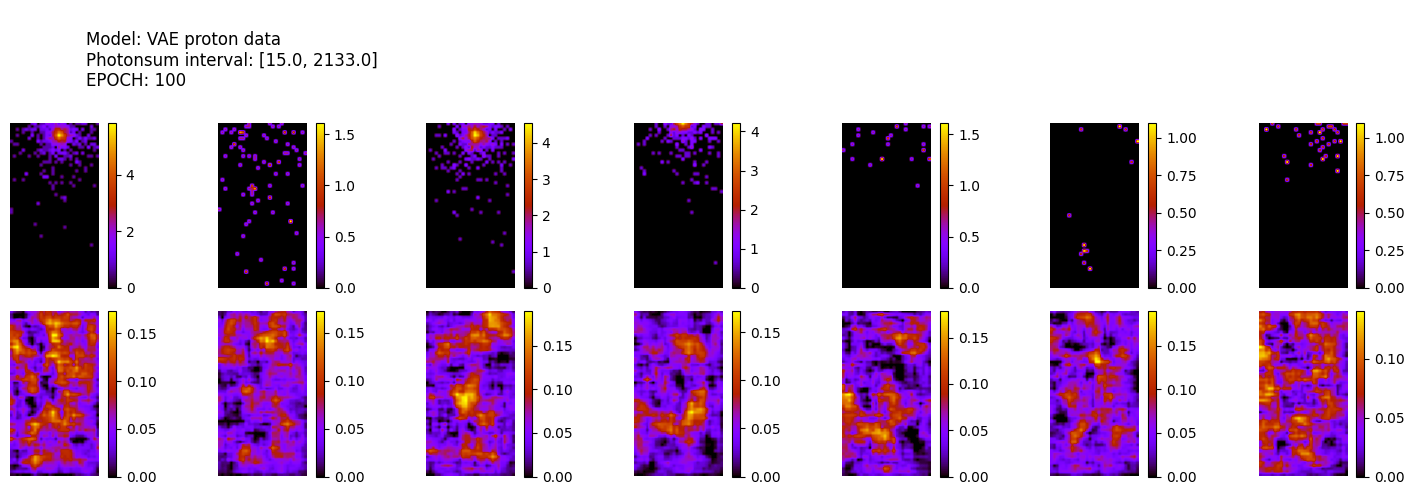

100 [Total loss: 53.07] [Recon_loss: 53.07] [KL loss: 0.00]
200 [Total loss: 39.21] [Recon_loss: 39.21] [KL loss: 0.00]
300 [Total loss: 41.45] [Recon_loss: 41.45] [KL loss: 0.00]


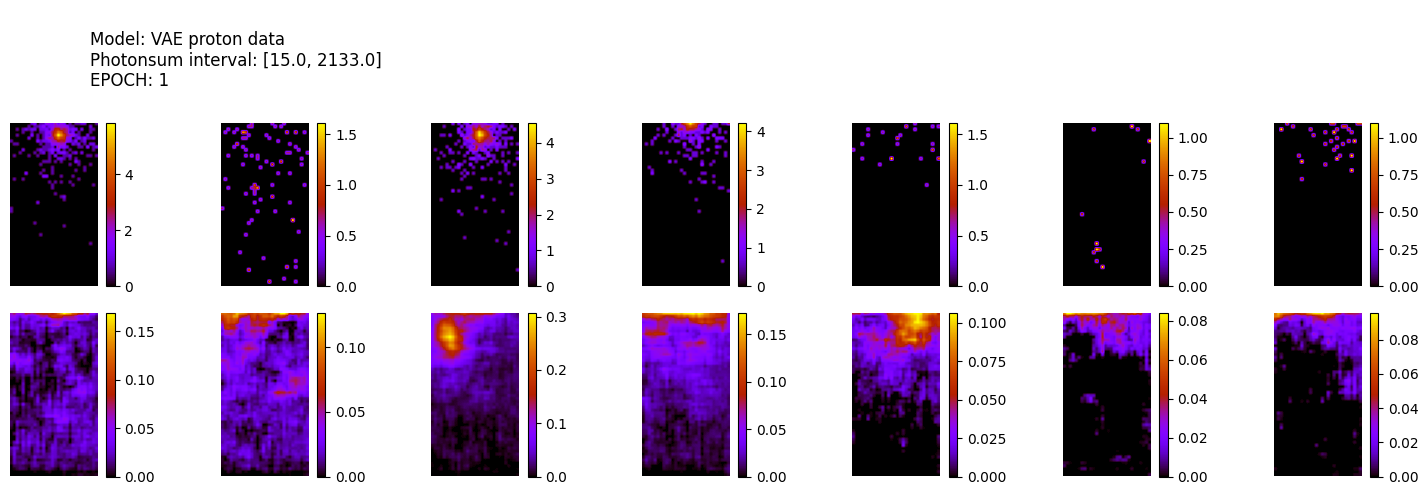

305/305 [==============================] - 2s 4ms/step
ws mean 46.80 ch1 0.03 ch2 8.70 ch3 0.38 ch4 108.09 ch5 116.79 Time for epoch 1 is 23.6667058467865 sec
400 [Total loss: 43.10] [Recon_loss: 43.10] [KL loss: 0.00]
500 [Total loss: 37.64] [Recon_loss: 37.64] [KL loss: 0.00]
600 [Total loss: 43.57] [Recon_loss: 43.57] [KL loss: 0.00]


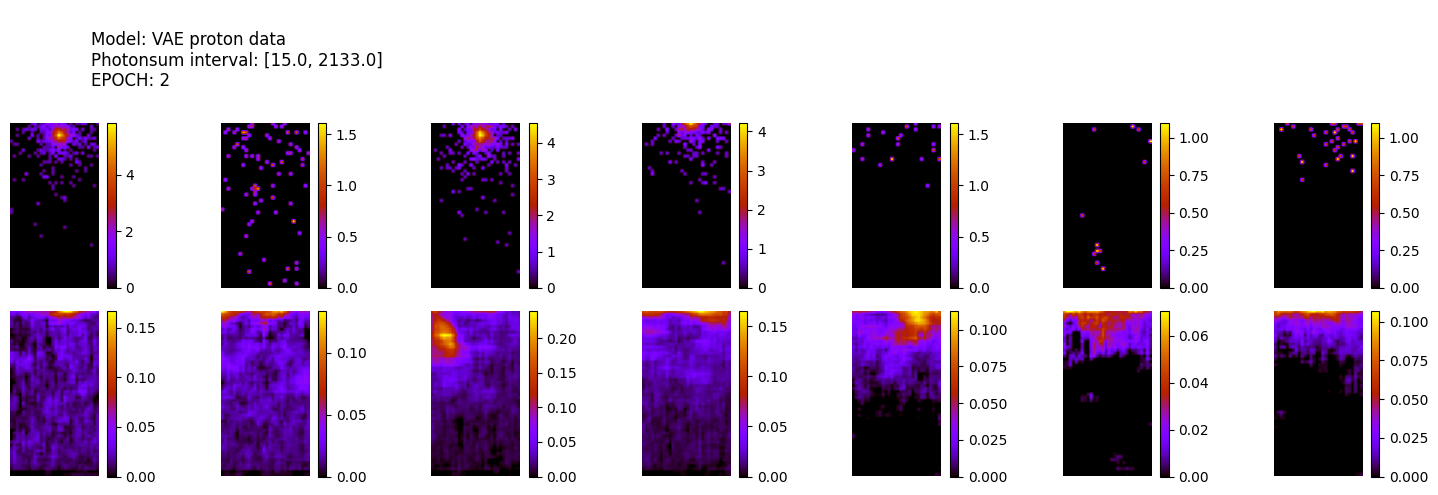

305/305 [==============================] - 1s 4ms/step
ws mean 47.48 ch1 0.03 ch2 9.41 ch3 0.39 ch4 109.06 ch5 118.53 Time for epoch 2 is 17.931071043014526 sec
700 [Total loss: 41.01] [Recon_loss: 41.01] [KL loss: 0.00]
800 [Total loss: 34.04] [Recon_loss: 34.04] [KL loss: 0.00]
900 [Total loss: 39.25] [Recon_loss: 39.25] [KL loss: 0.00]


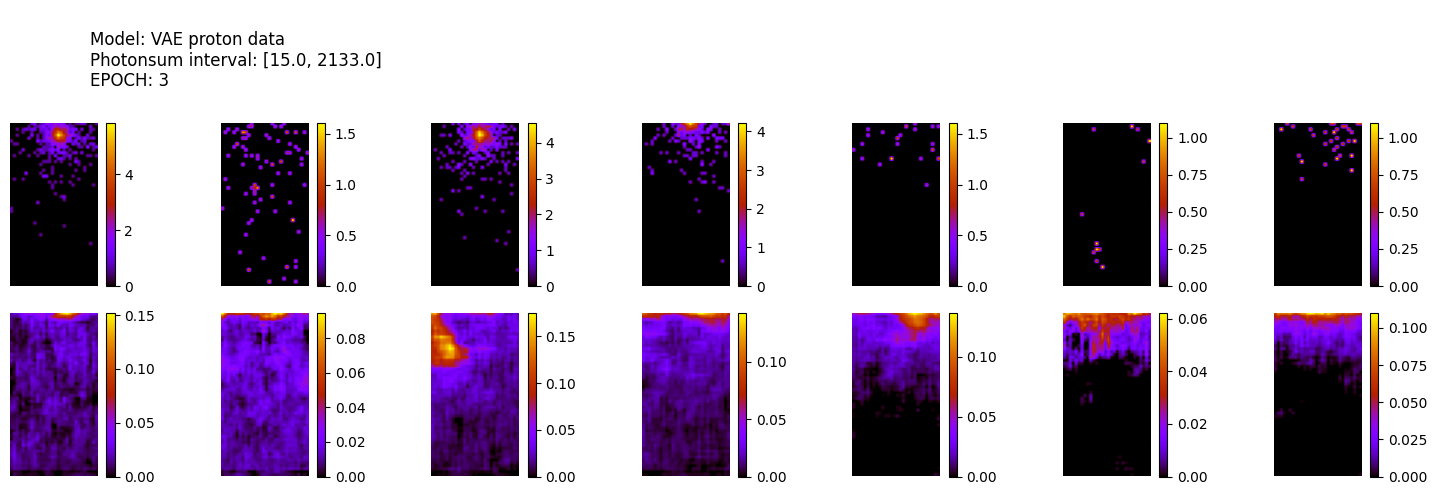

305/305 [==============================] - 1s 4ms/step
ws mean 47.92 ch1 0.03 ch2 9.86 ch3 0.39 ch4 109.71 ch5 119.60 Time for epoch 3 is 17.836960792541504 sec
1000 [Total loss: 42.06] [Recon_loss: 42.06] [KL loss: 0.00]


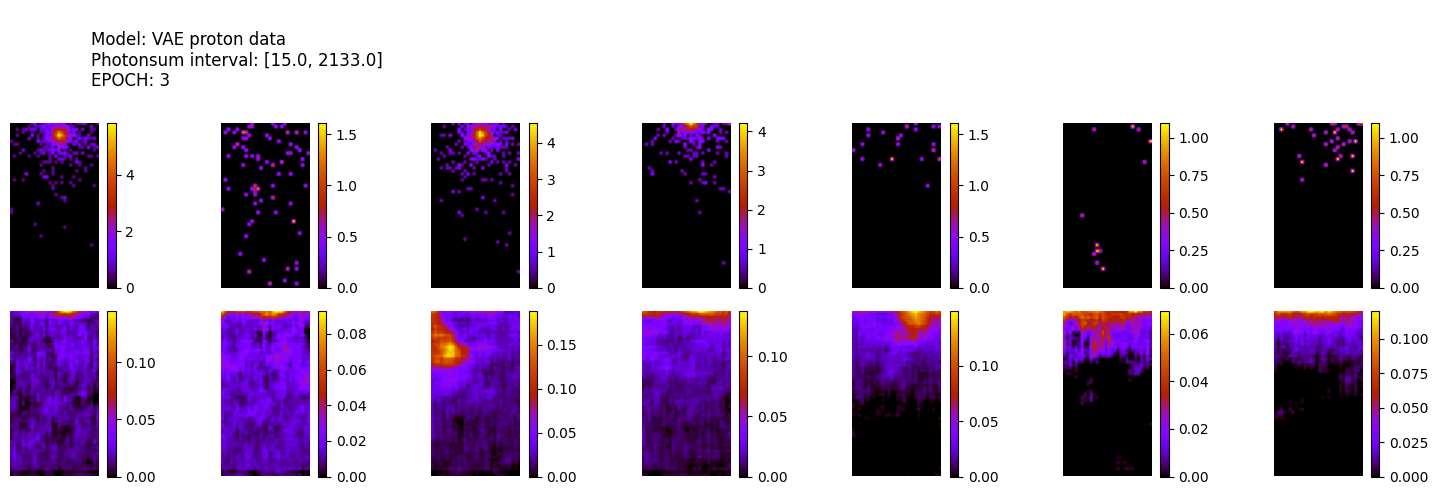

1100 [Total loss: 41.28] [Recon_loss: 41.28] [KL loss: 0.00]
1200 [Total loss: 39.06] [Recon_loss: 39.06] [KL loss: 0.00]


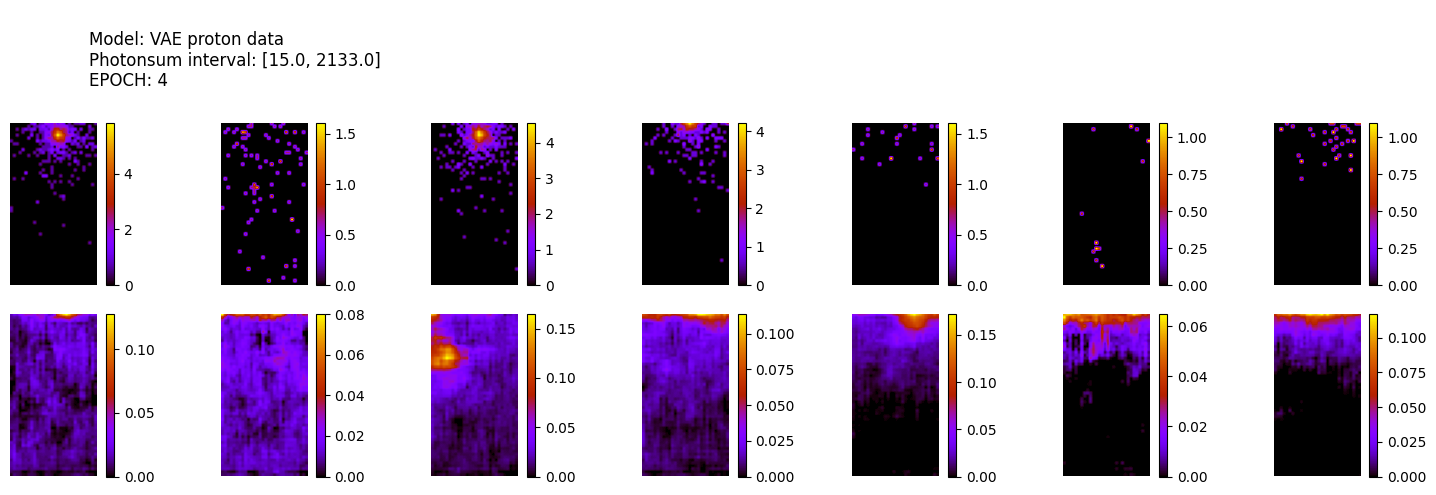

305/305 [==============================] - 1s 4ms/step
ws mean 48.07 ch1 0.03 ch2 10.09 ch3 0.39 ch4 109.86 ch5 119.98 Time for epoch 4 is 19.937144994735718 sec
1300 [Total loss: 42.30] [Recon_loss: 42.30] [KL loss: 0.00]
1400 [Total loss: 33.69] [Recon_loss: 33.69] [KL loss: 0.00]
1500 [Total loss: 43.85] [Recon_loss: 43.85] [KL loss: 0.00]


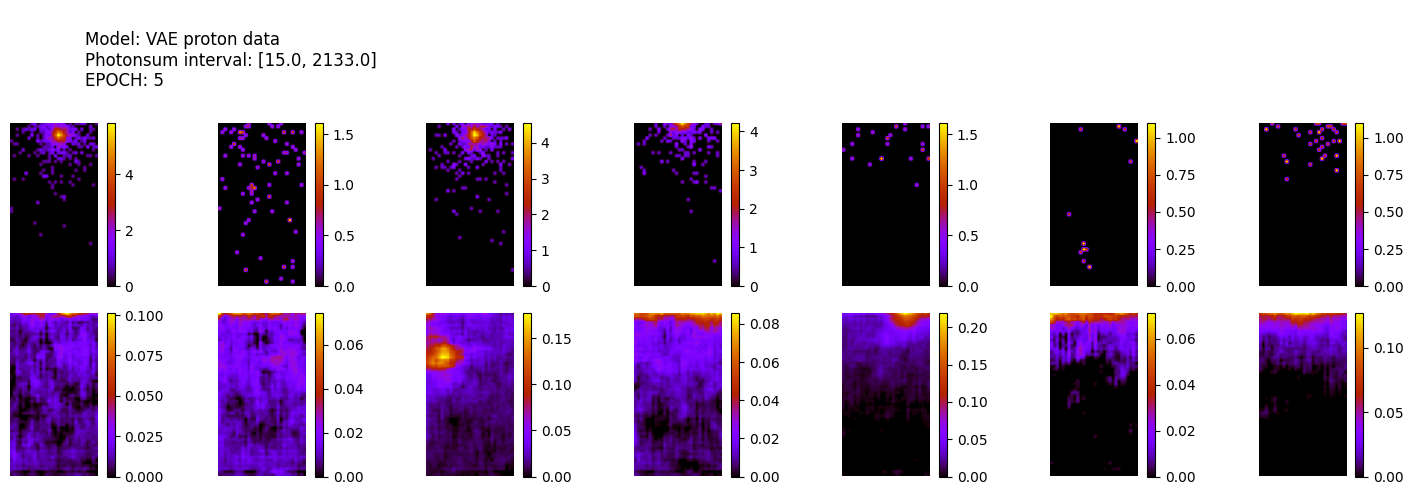

305/305 [==============================] - 1s 4ms/step
ws mean 47.93 ch1 0.03 ch2 10.11 ch3 0.39 ch4 109.50 ch5 119.62 Time for epoch 5 is 17.908241033554077 sec
1600 [Total loss: 38.17] [Recon_loss: 38.17] [KL loss: 0.00]
1700 [Total loss: 34.71] [Recon_loss: 34.71] [KL loss: 0.00]
1800 [Total loss: 36.27] [Recon_loss: 36.27] [KL loss: 0.00]


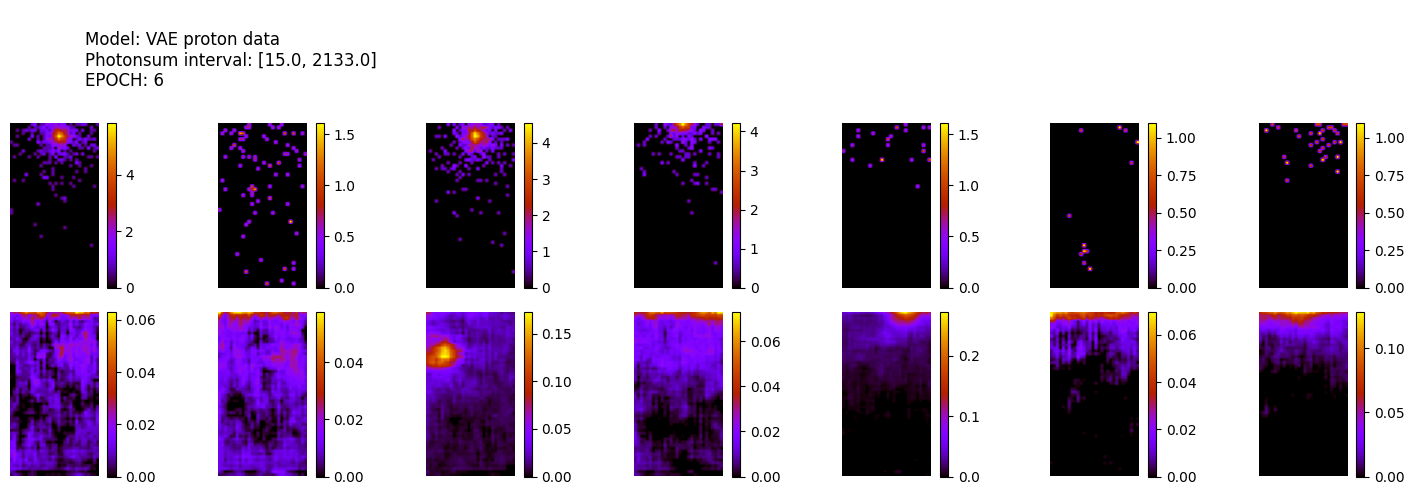

305/305 [==============================] - 1s 4ms/step
ws mean 48.66 ch1 0.03 ch2 10.86 ch3 0.39 ch4 110.56 ch5 121.48 Time for epoch 6 is 20.671424388885498 sec
1900 [Total loss: 42.98] [Recon_loss: 42.98] [KL loss: 0.00]
2000 [Total loss: 38.31] [Recon_loss: 38.31] [KL loss: 0.00]


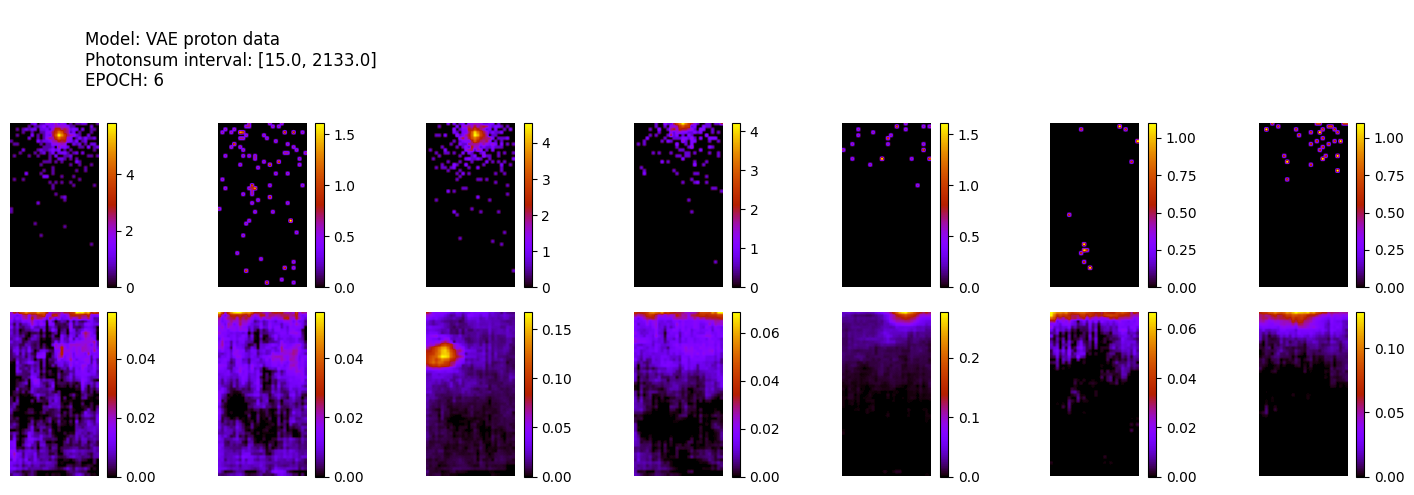

2100 [Total loss: 40.17] [Recon_loss: 40.17] [KL loss: 0.00]


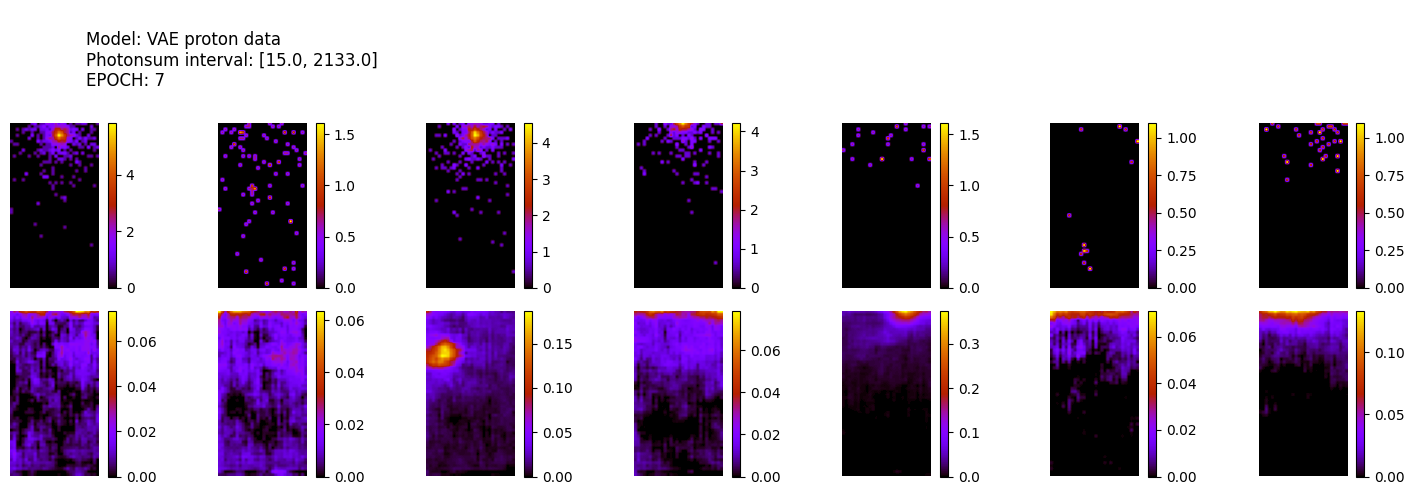

305/305 [==============================] - 1s 4ms/step
ws mean 48.57 ch1 0.03 ch2 10.96 ch3 0.39 ch4 110.24 ch5 121.25 Time for epoch 7 is 22.330204248428345 sec
2200 [Total loss: 32.63] [Recon_loss: 32.63] [KL loss: 0.00]
2300 [Total loss: 38.26] [Recon_loss: 38.26] [KL loss: 0.00]
2400 [Total loss: 42.90] [Recon_loss: 42.90] [KL loss: 0.00]


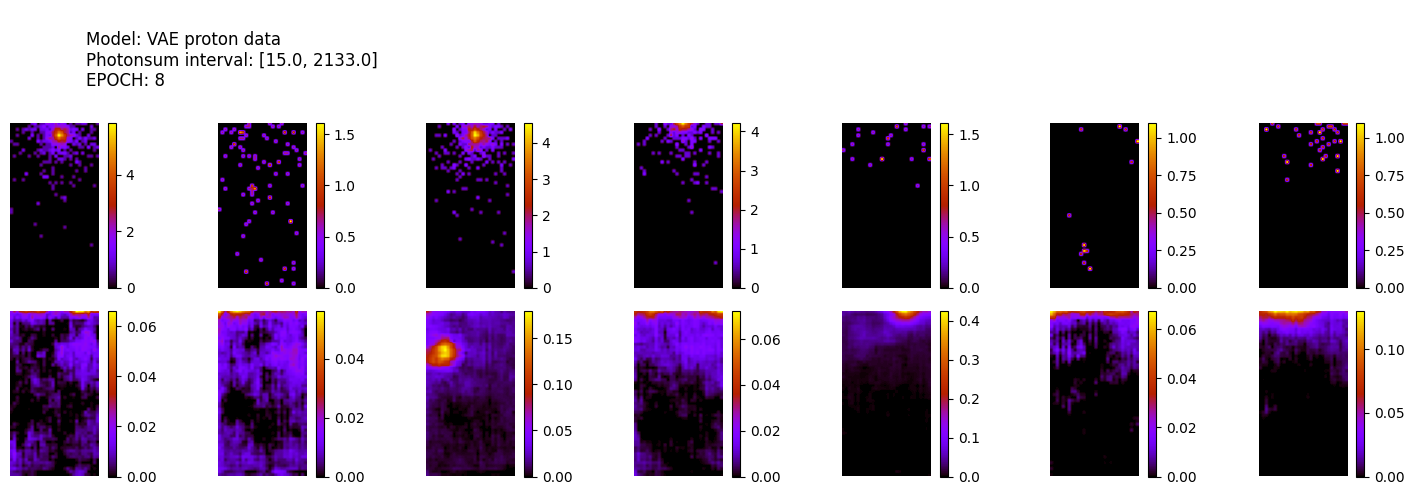

305/305 [==============================] - 1s 4ms/step
ws mean 49.14 ch1 0.03 ch2 11.53 ch3 0.39 ch4 111.07 ch5 122.66 Time for epoch 8 is 20.71378254890442 sec
2500 [Total loss: 39.36] [Recon_loss: 39.36] [KL loss: 0.00]
2600 [Total loss: 43.61] [Recon_loss: 43.61] [KL loss: 0.00]
2700 [Total loss: 34.32] [Recon_loss: 34.32] [KL loss: 0.00]


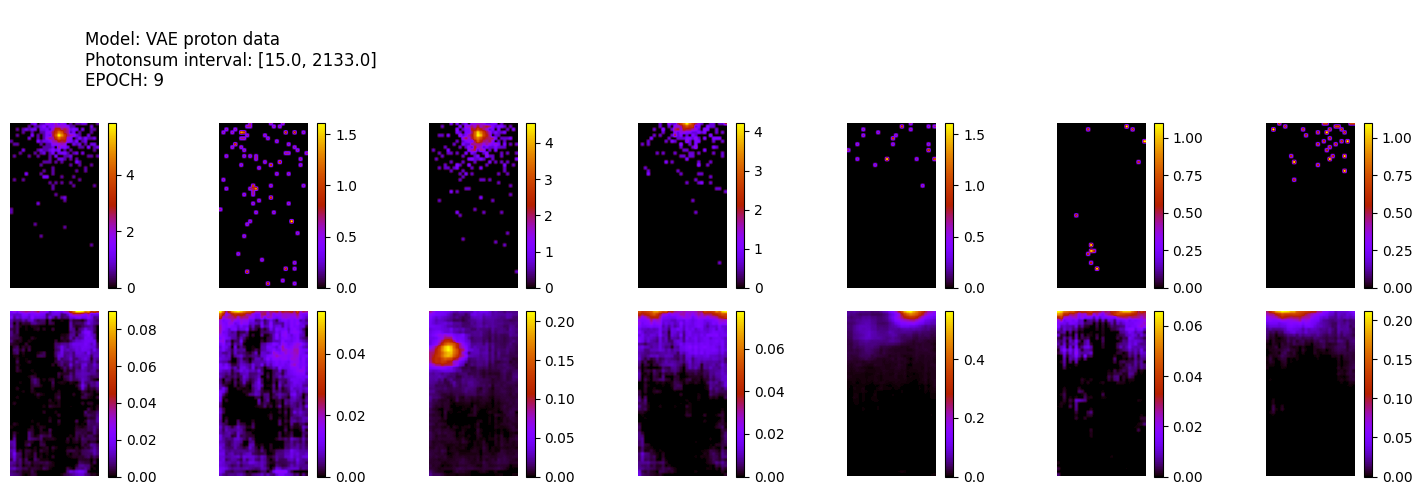

305/305 [==============================] - 1s 4ms/step
ws mean 48.93 ch1 0.03 ch2 11.64 ch3 0.39 ch4 110.43 ch5 122.16 Time for epoch 9 is 20.539941787719727 sec
2800 [Total loss: 41.56] [Recon_loss: 41.56] [KL loss: 0.00]
2900 [Total loss: 38.28] [Recon_loss: 38.28] [KL loss: 0.00]
3000 [Total loss: 38.82] [Recon_loss: 38.82] [KL loss: 0.00]


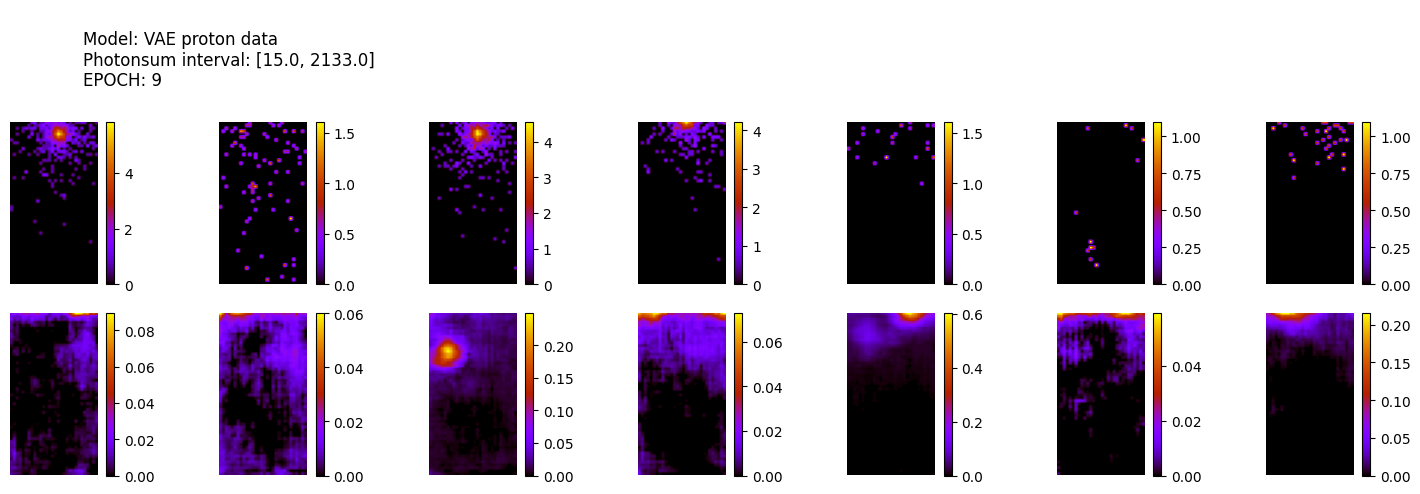

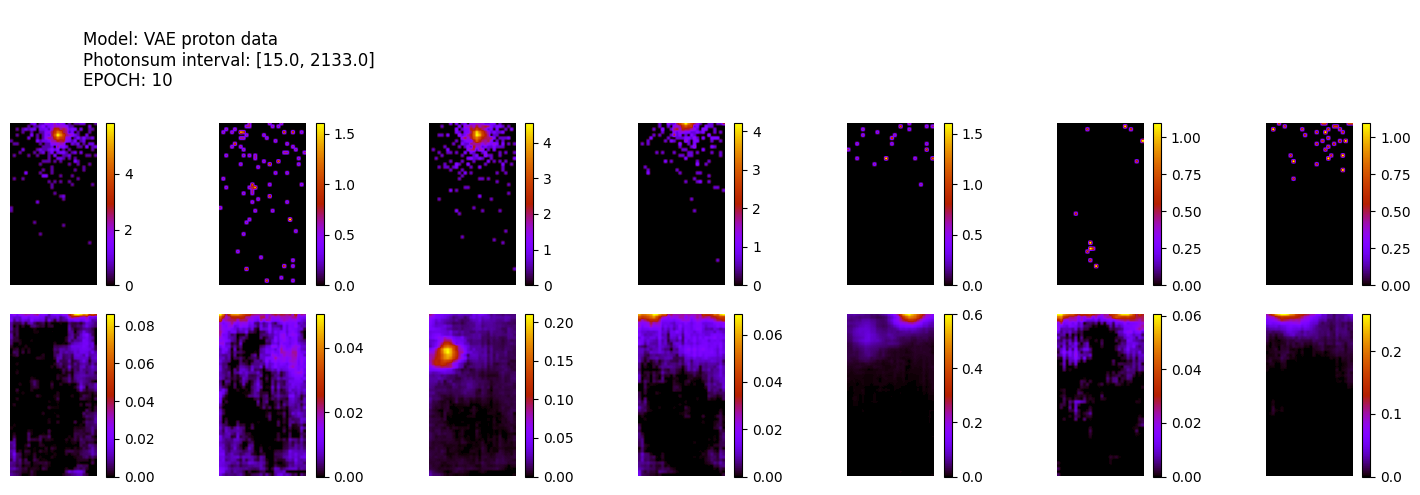

305/305 [==============================] - 1s 4ms/step
ws mean 49.00 ch1 0.03 ch2 11.66 ch3 0.39 ch4 110.60 ch5 122.32 Time for epoch 10 is 22.662789821624756 sec
3100 [Total loss: 43.92] [Recon_loss: 43.92] [KL loss: 0.00]
3200 [Total loss: 42.85] [Recon_loss: 42.85] [KL loss: 0.00]
3300 [Total loss: 37.57] [Recon_loss: 37.57] [KL loss: 0.00]


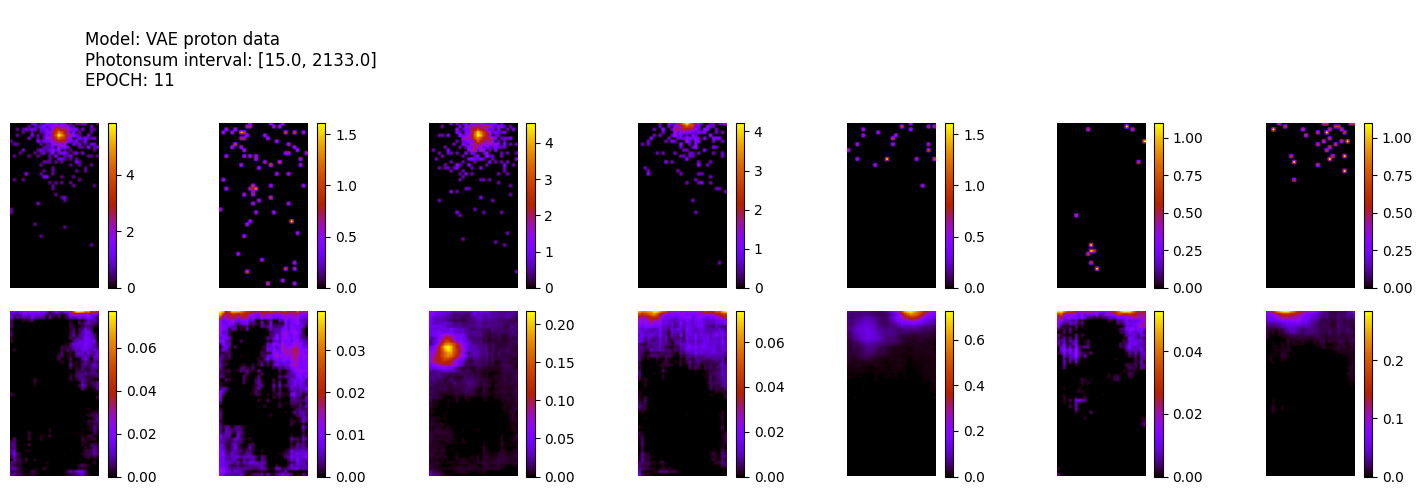

305/305 [==============================] - 1s 4ms/step
ws mean 49.37 ch1 0.04 ch2 12.08 ch3 0.39 ch4 111.09 ch5 123.28 Time for epoch 11 is 23.066256523132324 sec
3400 [Total loss: 41.18] [Recon_loss: 41.18] [KL loss: 0.00]
3500 [Total loss: 39.09] [Recon_loss: 39.09] [KL loss: 0.00]
3600 [Total loss: 30.30] [Recon_loss: 30.30] [KL loss: 0.00]


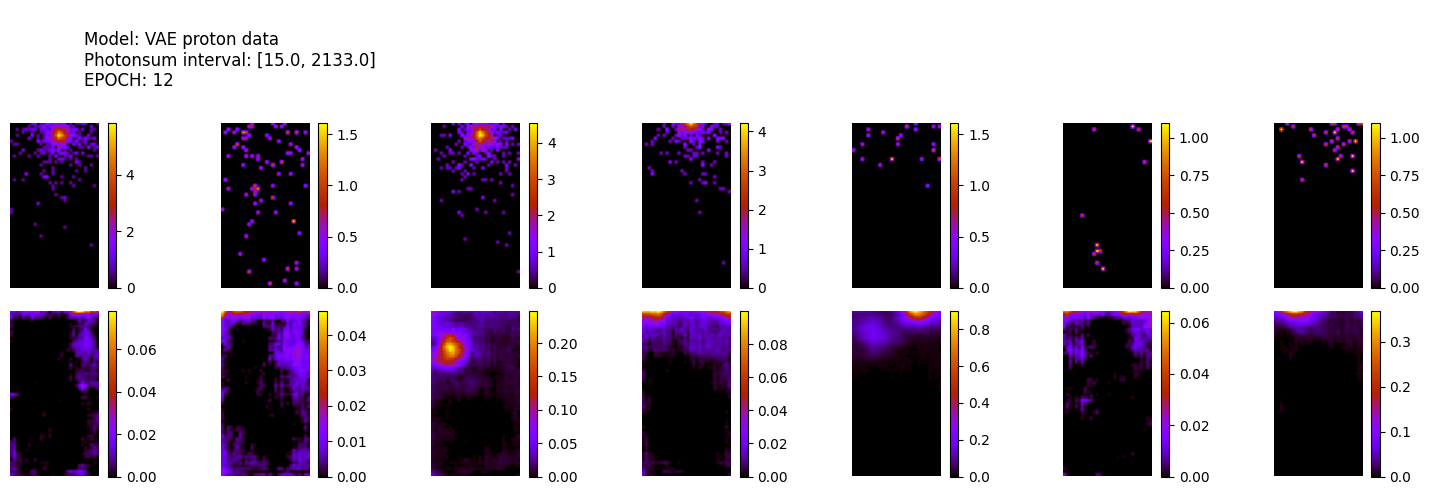

118/305 [==========>...................] - ETA: 0s

KeyboardInterrupt: 

In [21]:
history=train(dataset_with_cond, EPOCHS)

## Visualize losses

In [22]:
import seaborn as sns

sns.set_context('notebook', font_scale=1)

In [23]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [24]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [25]:
a4_dims = (14, 5)
def print_loss(loss_values, loss_str):
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    plt.yscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    plt.savefig(os.path.join(filepath_img, f"{loss_str}_loss"))

/tmp/ipykernel_16787/1025777419.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


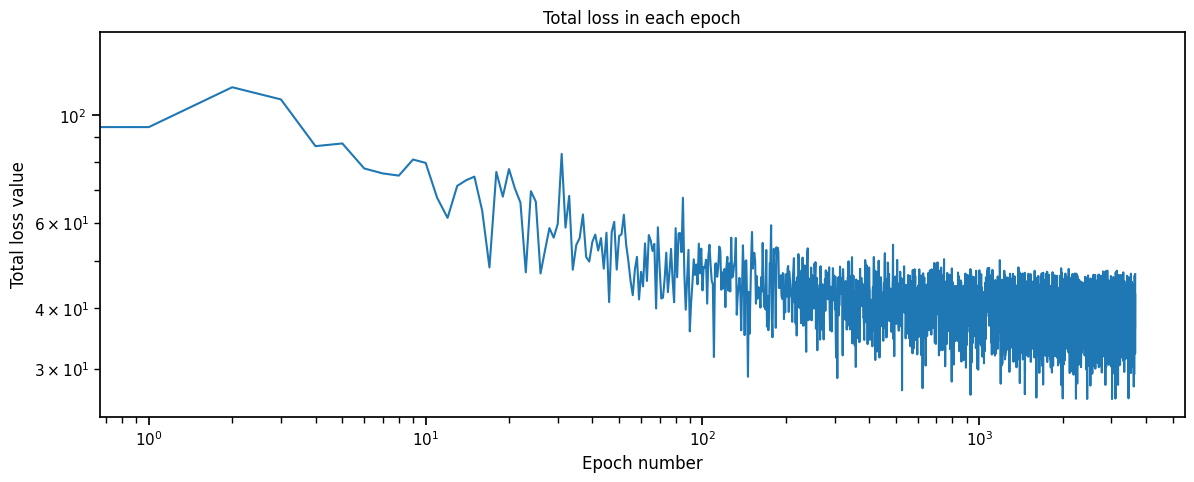

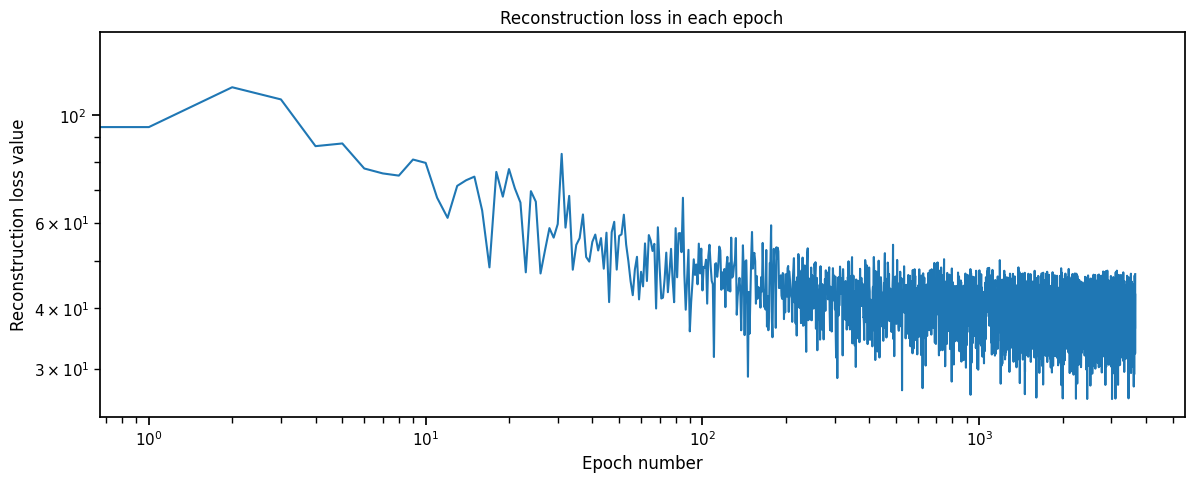

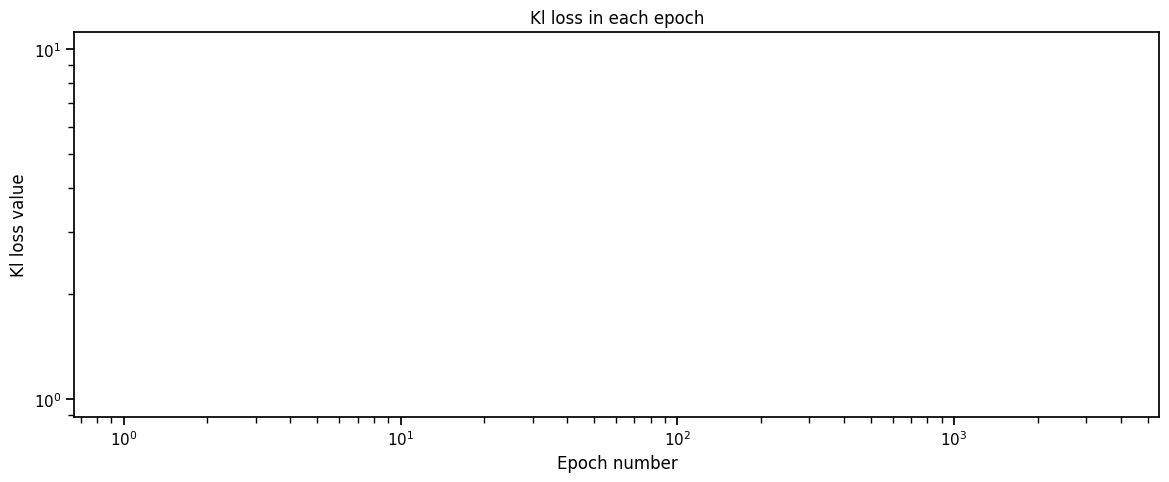

In [26]:
print_loss(total_loss, "Total")
print_loss(reconstruction_loss, "Reconstruction")
print_loss(kl_loss, "Kl")